## Задание 2
- Сделайте визуализацию ряда
- Разбейте его на компоненты
- Проверьте автокорреляцию
- Примените одну или несколько трансформаций, разобранных на лекции

In [18]:
# Импортируем нужные нам библиотеки
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(8, 6)})
sns.set(font_scale=2)
sns.set_style("whitegrid")


import math
import os
import shutil
import pyodbc
import sqlalchemy
import urllib
import re
import pandas as pd
from datetime import datetime, timedelta

warnings.filterwarnings("ignore")


In [719]:


def ts_split(df:pd.DataFrame, n_splits=5, n_test_samples = 100) -> pd.DataFrame:
    
    """делаем сплит для кроссвалидации"""
    
    n_train_samples = (len(df) - n_test_samples)//n_splits
    
    for i in range(1, n_splits+1):
        
        split_ind = n_train_samples*i
        
        filter_train = df.iloc[:split_ind].index
        filter_test = df.iloc[split_ind:split_ind+n_test_samples].index
        
        df.loc[df.index.isin(filter_train), f'split_{i}'] = 'train'
        df.loc[df.index.isin(filter_test), f'split_{i}'] = 'test'
    
    df.loc[df[f'split_{n_splits}'].isnull(), f'split_{n_splits}'] = 'test'
        
    return df

def cross_validation(df, data_name, pred_name, metrics = mae):
    """сгружаем сюда результат работы ts_split, возвращаем тензор метрик на каждый сплит и средние метрики по всем сплитам"""
    
    split_cols = [col for col in df.columns if 'split' in col]
    results = {}
    
    for i in df[split_cols].columns:    
        tmp_train = df[df[i] == 'train']
        tmp_test = df[df[i] == 'test']
        metrics_train = metrics(tmp_train[data_name], tmp_train[pred_name])
        metrics_test = metrics(tmp_test[data_name], tmp_test[pred_name])
        
        results.update({i:{'train' : metrics_train, 
                           'test' : metrics_test}})
    
    results_per_split = pd.DataFrame(results)
    mean_results = pd.DataFrame()
    
    #for index, column in enumerate(['mae']):#['r2_s_rate', 's_rate', 'r2']):
    #    mean_results[column] = results_per_split.apply(lambda row: [row[index] for row in row], axis = 0).mean(axis = 1)
    
    return results_per_split.T, mean_results

def autocorr(srs:pd.Series, target_name):
    result = {}
    for i in range(1, len(srs)):
        srs_shifted = srs.copy()
        srs_shifted['shifted'] = srs.shift(i)
        srs_shifted = srs_shifted.iloc[i:] # делаю срез, чтобы не считать корреляцию вещ. значений и np.nan
        auto_corr = srs_shifted[target_name].corr(srs_shifted.shifted)
        result.update({i:auto_corr})
    return pd.Series(result)

## Это для загрузки датасета


def sql_column_renamer(dict_):
    string_ = ''
    for k, v in dict_.items():
        k= f'{k} as {v}'    
        string_+=f', {k}'
    return string_[2:]

#def db_connection(server=, database=, user=, password=):
    
#    engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}"\
#        .format(urllib.parse.quote_plus("DRIVER=SQL Server Native Client 11.0;SERVER={0};\
#        PORT=1433;DATABASE={1};UID={2};PWD={3};TDS_Version=8.0;".format(server, database, user, password))),echo=False)
#    return engine

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Получаем датасет

In [46]:
sales_dict = dict(zip(['attr178.p1016'],
                ['load_date']))

engine = db_connection()
with engine.connect() as connection:
        
    orders_188 = pd.read_sql_query(
        f"\
    SELECT {sql_column_renamer(sales_dict)}, SUM(attr188.p1460) as total_sales  \
    FROM attr188 \
    left join attr150 \
    on attr150.objectid = attr188.p1082\
    left join attr178 on attr178.ObjectID = attr188.p1078\
    where attr178.p1521  = 1 AND YEAR(attr178.p1016) >=2013\
    group by attr178.p1016\
    ;", connection)

In [47]:
orders_188.head()

,load_date,total_sales
0,2016-12-09,425931.14
1,2017-11-06,15416.87
2,2018-10-04,313951.79
3,2020-07-29,669790.39
4,2013-07-24,345278.45


### Преобразуем в ts с поквартальной разбивкой

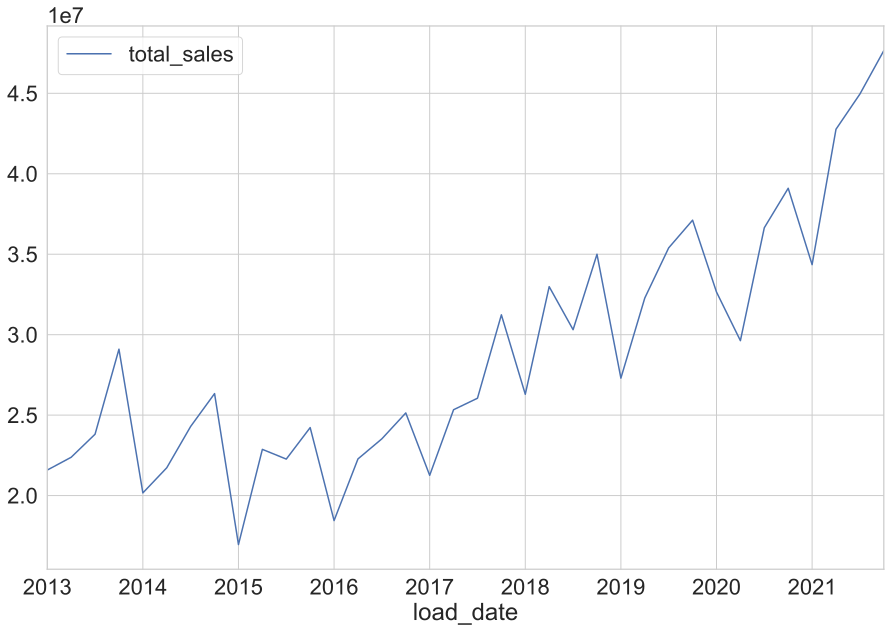

In [48]:
orders_188['load_date'] = pd.to_datetime(orders_188['load_date'], errors = 'coerce')

orders_188.set_index('load_date', drop=True, inplace=True)

orders_month = orders_188.resample('M').sum()
orders_quarter = orders_188.resample('Q').sum()
orders_quarter.plot()

## Считаем автокорреляцию

In [49]:
def autocorr(srs:pd.Series, target_name):
    result = {}
    for i in range(1, len(srs)):
        srs_shifted = srs.copy()
        srs_shifted['shifted'] = srs.shift(i)
        #srs_shifted = srs_shifted.iloc[i:] # делаю срез, чтобы не считать корреляцию вещ. значений и np.nan
        auto_corr = srs_shifted[target_name].corr(srs_shifted.shifted)
        result.update({i:auto_corr})
    return pd.Series(result)

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

[]

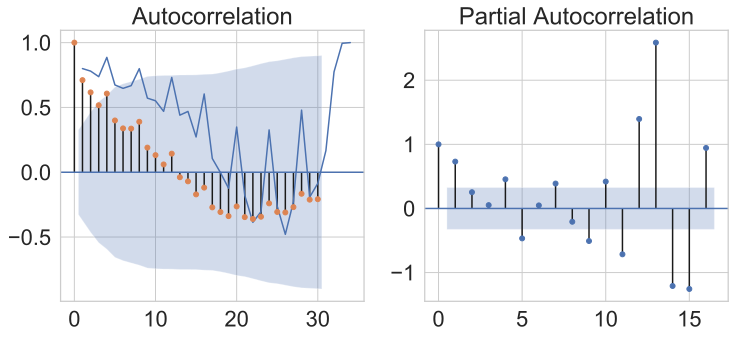

In [51]:
fig, axes = plt.subplots(nrows = 1, ncols =2, sharex=False, sharey=False, figsize = (12,5), )
axes[0].plot(autocorr(orders_quarter, 'total_sales'))
plot_acf(orders_quarter, ax = axes[0], lags = 30)
plot_pacf(orders_quarter, ax = axes[1])
plt.plot()

плохо понимаю, почему графики различаются так сильно.  
На примитивном графике явно прослеживается сезонность с лагом 4,  на модном из библиотеки - значения странные, но сезонность также прослеживается, хоть и  менее явно, частичная авторкорреляция принимает очень странные значения по игреку - ничего не понятно.

### Разбиваем ряд на компоненты

In [52]:
result_sot = seasonal_decompose(orders_quarter, model='additive', period = 4)

[]

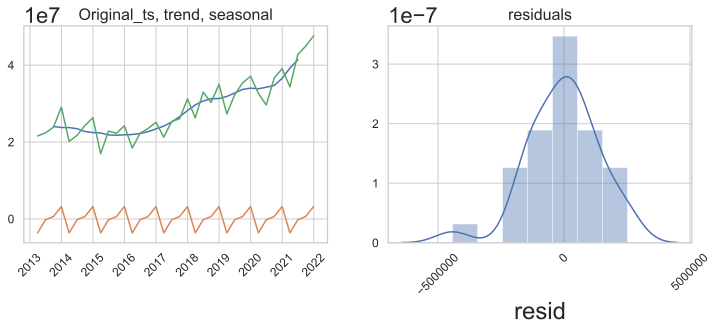

In [53]:
fig, axes = plt.subplots(nrows = 1, ncols =2, sharex=False, sharey=False, figsize = (12,4), )

axes[0].set_title('Original_ts, trend, seasonal', fontsize = 16)
axes[0].plot(result_sot.trend)
axes[0].plot(result_sot.seasonal)
axes[1].set_title('residuals', fontsize = 16)
sns.distplot(result_sot.resid, ax=axes[1])
axes[0].plot(orders_quarter)


for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=12, verticalalignment = 'top')
    plt.yticks(fontsize=12)
plt.plot()


пробовал разные варианты (понедельный, помесячный и пр), у квартального самые красивые остатки.

### Преобразование ряда в стационарный

In [56]:
import statsmodels

In [59]:
?statsmodels.tsa.stattools.adfuller

In [57]:
#Для начала убедимся что ряд нестационарный через тест Дики-Фуллера

def dfuller_(ts:pd.Series, regression = 'ct'):
    d_f_names = ['adf_', 'pvalue_', 'used_lag', 'nobs', 'critical_values', 'icbest', 'resstore']
    result = pd.Series(dict(zip(d_f_names,statsmodels.tsa.stattools.adfuller(ts, regression = regression))))
    
    return result

In [58]:
dfuller_(orders_quarter)

adf_                                                          -1.327
pvalue_                                                     0.881087
used_lag                                                           8
nobs                                                              27
critical_values    {'1%': -4.339881664888482, '5%': -3.5877977071...
icbest                                                       821.299
dtype: object

In [914]:
dfuller_(orders_quarter)['critical_values']

{'1%': -4.339881664888482,
 '5%': -3.5877977071584612,
 '10%': -3.2293340725499164}

 Значение статистики сильно правее критических значений. Pvalue 0.88 - отвергаем нулевую гипотезу. Раз тренд нелинейный попробуем Power Transform

## Power transform

In [60]:
from scipy.optimize import curve_fit

def func(x,p,a):
    return x**p+a

x = [i for i in range(len(orders_quarter))]

popt, _ = curve_fit(func,x,  orders_quarter['total_sales'])
p = popt[0]
a = popt[1]
print(p,a)


4.780574448216449 24315536.97088241


In [61]:
y_hat = func(x,p,a)

In [62]:
orders_quarter_pow_transform = orders_quarter.copy()

In [63]:
orders_quarter_pow_transform['predict'] = y_hat
residuals = orders_quarter_pow_transform['total_sales'] - orders_quarter_pow_transform['predict'] 

[]

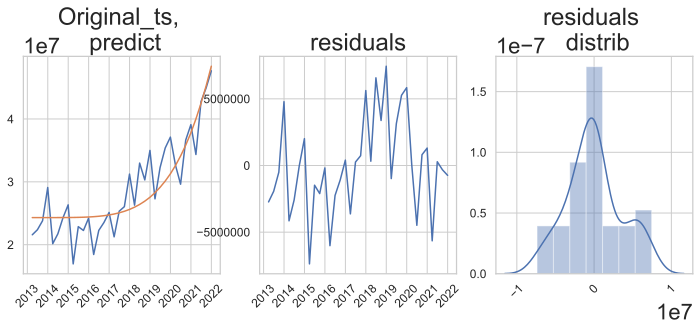

In [64]:
fig, axes = plt.subplots(nrows = 1, ncols =3, sharex=False, sharey=False, figsize = (12,4))

axes[0].set(title='Original_ts, \n predict', )
axes[0].plot(orders_quarter_pow_transform)
axes[1].set(title='residuals',)
axes[1].plot(residuals)

axes[2].set(title='residuals \n distrib',)
sns.distplot(residuals, ax=axes[2])

for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=12, verticalalignment = 'top')
    plt.yticks(fontsize=12)
plt.plot()



In [65]:
p_t_residuals_decompose = seasonal_decompose(residuals, model='additive', period = 4)

[]

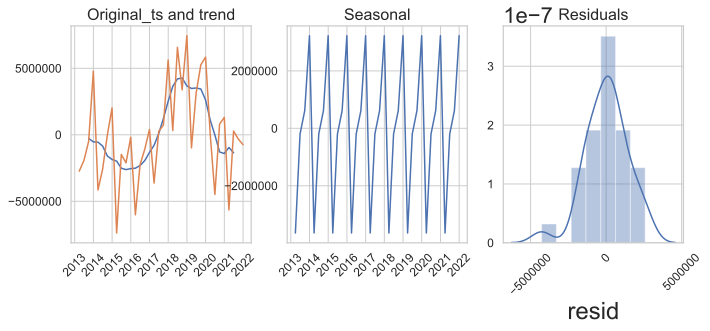

In [66]:
fig, axes = plt.subplots(nrows = 1, ncols =3, sharex=False, sharey=False, figsize = (11,4), )


axes[0].set_title('Original_ts and trend',size=16)
axes[0].plot(p_t_residuals_decompose.trend)
axes[0].plot(residuals)

axes[1].set_title('Seasonal', size = 16)
axes[1].plot(p_t_residuals_decompose.seasonal)

axes[2].set_title('Residuals', fontsize = 16)
sns.distplot(p_t_residuals_decompose.resid, ax=axes[2])



for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=12, verticalalignment = 'top')
    plt.yticks(fontsize=12)

plt.plot()

Сезонная компонента остатков такая же как у оригинального ряда, смущает тренд, но он такой из-за ковидного ускорения, которое получили продажи после того, как тренд оригинального ряда уже было приобрел логистический вид, но получил мощный импульс в 20 году

In [67]:
dfuller_(residuals, regression = 'c')

adf_                                                        -3.30783
pvalue_                                                     0.014532
used_lag                                                          10
nobs                                                              25
critical_values    {'1%': -3.7238633119999998, '5%': -2.98648896,...
icbest                                                       816.549
dtype: object

In [68]:
dfuller_(residuals).critical_values

{'1%': -4.3749647199999995, '5%': -3.6034675359999997, '10%': -3.23818632}

Тем не менее, значение критерия левее 5% критического значения, значит нулевую гипотезу можем отвергнуть, остатки после power transform стационарны

## Дифференцирование

Логика подсказывает, что одного порядка дифференцирования не хватит, т.к. ранее мы выяснили, что тренд нелинейный, проверим предварительно отрезав последние 4 значения - это будет тест на потом

In [69]:
dfuller_(orders_quarter.diff(1)[1:-4], regression = 'c')

adf_                                                        -1.76962
pvalue_                                                     0.395645
used_lag                                                           4
nobs                                                              26
critical_values    {'1%': -3.7112123008648155, '5%': -2.981246804...
icbest                                                       682.562
dtype: object

Не можем отвергнуть нулевую гипотезу, ряд нестацинарен.

In [70]:
dfuller_(orders_quarter.diff().diff()[2:-4], regression = 'c')

adf_                                                        -7.42963
pvalue_                                                  6.41139e-11
used_lag                                                           3
nobs                                                              26
critical_values    {'1%': -3.7112123008648155, '5%': -2.981246804...
icbest                                                       651.478
dtype: object

двойного дифференцирования хватило - ряд стационарен

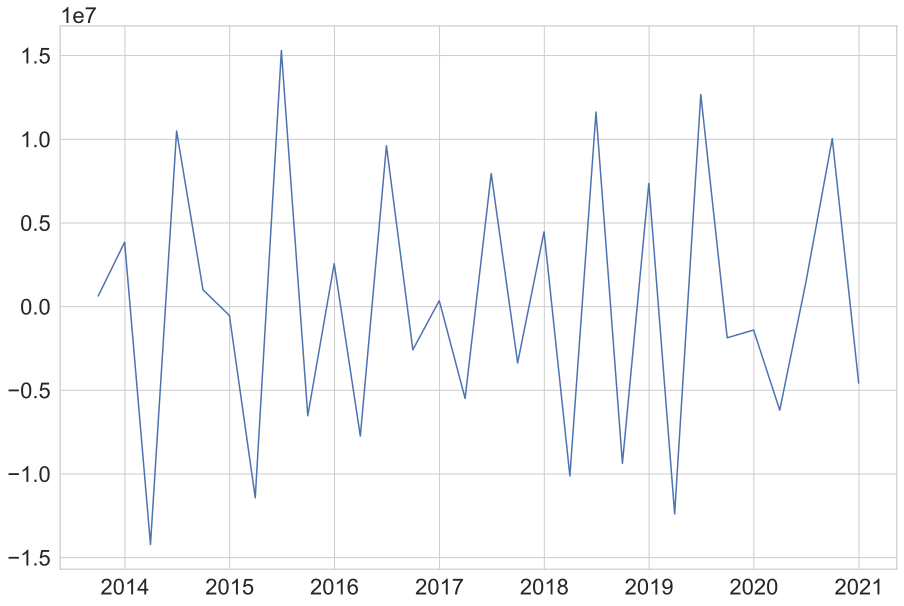

In [71]:
plt.plot(orders_quarter.diff().diff()[2:-4])

## Логарифмирование

In [72]:
orders_quarter_log = np.log(orders_quarter)
orders_quarter_log.head()

,total_sales
load_date,
2013-03-31,16.887546
2013-06-30,16.923749
2013-09-30,16.985804
2013-12-31,17.186168
2014-03-31,16.819556


In [73]:
dfuller_(orders_quarter_log, regression='c')

adf_                                                         2.08253
pvalue_                                                     0.998771
used_lag                                                           3
nobs                                                              32
critical_values    {'1%': -3.653519805908203, '5%': -2.9572185644...
icbest                                                      -40.5335
dtype: object

H0 не может быть отвергнута, ряд нестационарный

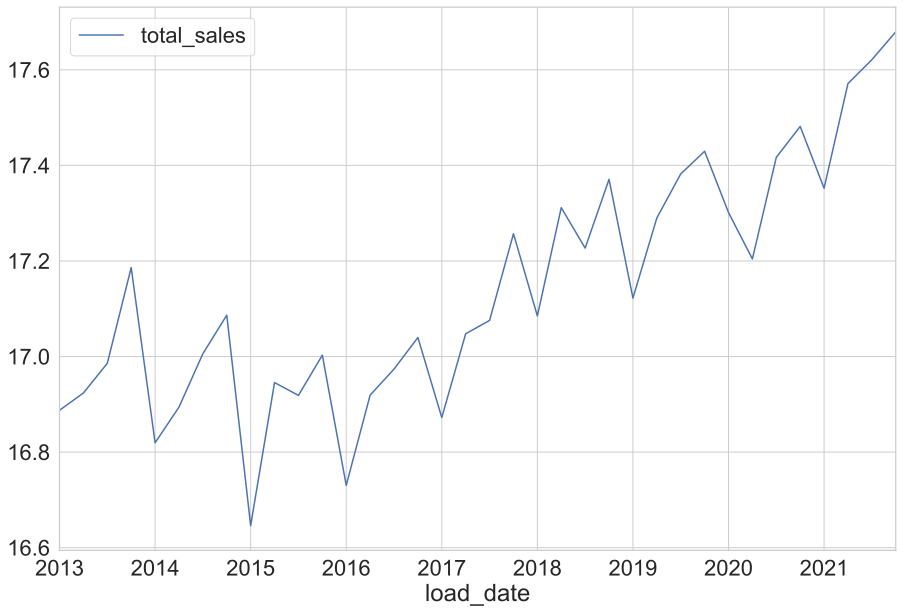

In [74]:
orders_quarter_log.plot()

## Преобразование Бокса Кокса

In [75]:
import scipy.stats as scs

In [76]:
orders_quarter.head()

,total_sales
load_date,
2013-03-31,21585802.96
2013-06-30,22381583.17
2013-09-30,23814461.98
2013-12-31,29097637.52
2014-03-31,20166963.50


In [77]:
# функция для преобразования и поиска оптимальной лямбды
box_cox_, lmbda = scs.boxcox(orders_quarter['total_sales'])

In [78]:
lmbda

-0.5030326304177588

In [79]:
dfuller_(box_cox_, regression='c')

adf_                                                        0.626077
pvalue_                                                     0.988241
used_lag                                                           4
nobs                                                              31
critical_values    {'1%': -3.661428725118324, '5%': -2.9605253412...
icbest                                                      -475.472
dtype: object

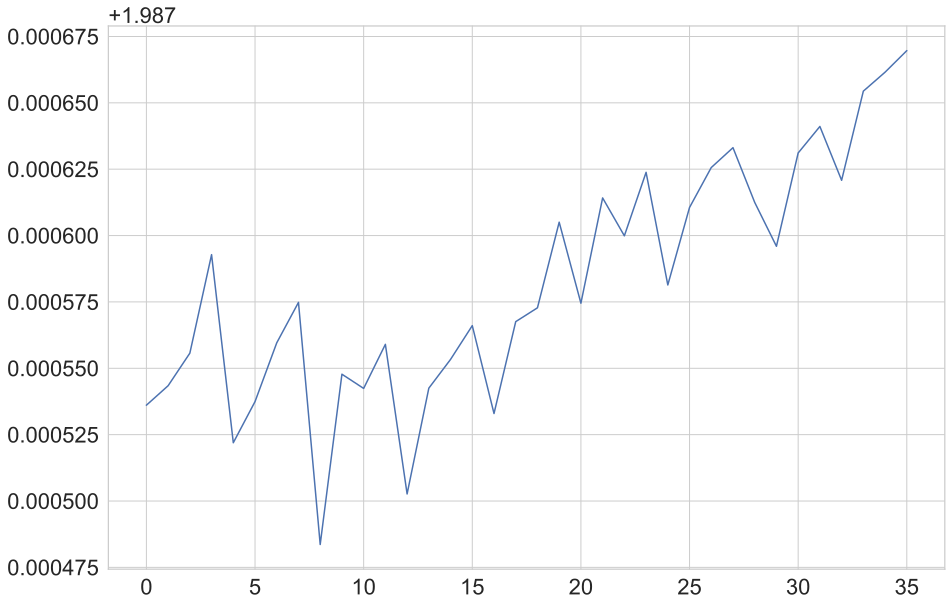

In [80]:

pd.Series(box_cox_).plot()     

H0 не может быть отвергнута, ряд нестационарный

___
**Выводы:**
- В моем случае работает только Power Transform и двойное дифференцирование
- Остальные преобразования(boxcox и логарифмирование) не работают для квадратичного тренда

## Домашнее задание 3

- Датасет аггрегировать по неделям - если не возражаете, оставлю квартальную разбивку, т.к. она самая красивая
- Простое экспоненциальное сглаживание
- Двойное экспоненциальное сглаживание
- Тройное экспоненциальное сглаживание (тип модели additive или multiplicative) выбрать самостоятельно
- Для финального отчета сделать кросс-валидацию, пояснить выбранные метрики, а так же их финальные значения.

In [477]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error as mae


In [478]:
#Оставим кусочек данных для финальной валидации
orders_quarter_train = orders_quarter.iloc[:-4]
orders_quarter_test = orders_quarter.iloc[-4:]

In [479]:
#Сделаем сплит для кросс-валидации
orders_quarter_train = ts_split(orders_quarter_train, n_splits=4, n_test_samples = 4)

*Для простого и двойного сглаживания будем использовать MAE, другие метрики типа R2 скорее всего будут работать совсем плохо, т.к. пики будут сглаживаться и, как следствие, дисперсия оригинального ряда будет сильно отличаться от дисперсии предсказанного ряда*

### Simple exponential smoothing ###

Поперебираем альфу в поисках лучшей:

In [480]:
result = {}
for i in range(1,20):
    
    ses_model = SimpleExpSmoothing(orders_quarter_train.total_sales)\
                .fit(smoothing_level=1/i,
                     optimized=False,
                     use_brute=True)
    
    orders_quarter_train['ses_prediction'] = ses_model.fittedvalues
    
    tmp = cross_validation(orders_quarter_train, 
                           data_name='total_sales', 
                           pred_name = 'ses_prediction')[0].mean().to_dict()
    result.update({i:tmp})

pd.DataFrame(result).T.sort_values(by = 'test').head(3)
    

,train,test
4,2.609729e+06,3.313416e+06
3,2.655846e+06,3.349595e+06
5,2.606112e+06,3.402018e+06


Лучшая альфа - 1/4, запишем результат в исходный ДФ

In [481]:
ses_model = SimpleExpSmoothing(orders_quarter_train.total_sales).fit(smoothing_level=1/4,optimized=False,use_brute=True)
orders_quarter_train['ses_prediction']=ses_model.fittedvalues

ses_mae = dict(cross_validation(orders_quarter_train, data_name='total_sales', pred_name = 'ses_prediction')[0].mean())

metrics = {'ses_mae': ses_mae}
metrics

{'ses_mae': {'train': 2609729.1528487625, 'test': 3313416.161349059}}

### Double exponential smoothing ###

Тренд, как мы выяснили у нас нелинейный, будем счиать его мультипликативно

In [482]:
des_model = ExponentialSmoothing(orders_quarter_train.total_sales, trend='mul').fit()

orders_quarter_train['des_prediction']=des_model.fittedvalues

In [483]:
des_mae = dict(cross_validation(orders_quarter_train, data_name='total_sales', pred_name = 'des_prediction')[0].mean())

In [484]:
metrics.update({'des_mae': des_mae})
metrics

{'ses_mae': {'train': 2609729.1528487625, 'test': 3313416.161349059},
 'des_mae': {'train': 2408432.3537789327, 'test': 2988400.164131755}}

### Triple exponential smoothing ###
Мудрствовать лукаво также  не будем, уже знаем что тренд нужно счиать мультипликативно, сезонность 4 - это мы выяснили на прошлом ДЗ, останется только проверить как ее считать: аддитивно или мультипликативно, тренд тушить не будем. 


In [485]:
tes_model = ExponentialSmoothing(orders_quarter_train.total_sales, trend='mul', seasonal='mul',seasonal_periods=4).fit()

orders_quarter_train['tes_prediction']=tes_model.fittedvalues

In [486]:
tes_mae = dict(cross_validation(orders_quarter_train, data_name='total_sales', pred_name = 'tes_prediction')[0].mean())
metrics.update({'tes_mae': tes_mae})
metrics = pd.DataFrame(metrics).T['test'].reset_index()

### Итоги

[]

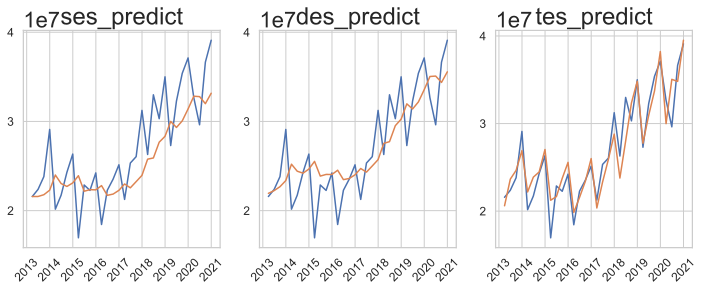

In [487]:
fig, axes = plt.subplots(nrows = 1, ncols =3, sharex=False, sharey=False, figsize = (12,4))

axes[0].set(title='ses_predict', )
axes[0].plot(orders_quarter_train[['total_sales', 'ses_prediction']])

axes[1].set(title= 'des_predict')
axes[1].plot(orders_quarter_train[['total_sales', 'des_prediction']])

axes[2].set(title= 'tes_predict')
axes[2].plot(orders_quarter_train[['total_sales', 'tes_prediction']])



for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=12, verticalalignment = 'top')
    plt.yticks(fontsize=12)
plt.plot()


[]

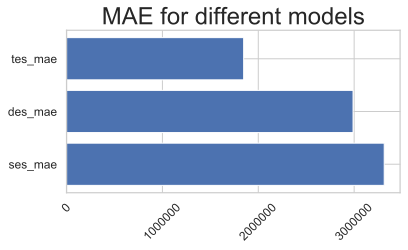

In [488]:
plt.figure(figsize=(6, 3))

plt.barh(metrics['index'], metrics.test)
plt.title('MAE for different models')
plt.xticks(rotation=45, fontsize=12, verticalalignment = 'top')
plt.yticks(fontsize=12)
plt.plot()

In [489]:
metrics

,index,test
0,ses_mae,3.313416e+06
1,des_mae,2.988400e+06
2,tes_mae,1.847440e+06


## Проверим результаты лучшей модели на отложенной выборке

In [490]:
orders_quarter_test['tes_pred'] = tes_model.forecast(4)

In [491]:
orders_quarter_test

,total_sales,tes_pred
load_date,,
2021-03-31,34352222.77,3.126917e+07
2021-06-30,42767467.13,3.511943e+07
2021-09-30,44954072.89,3.753725e+07
2021-12-31,47650879.14,4.160195e+07


In [493]:
# предсказать это ковидное ускорение действительно было сложно.

## Домашнее задание 4##
### ARIMA ###
- На выбор построить общую модель количества заказов в день илбо разделить данные на три временных ряда для каждого меню отдельно
- В случае общей модели данные нужно агрегировать, чтобы посчитать общее количество заказов за день
- По желанию можно можно сменить частоту с дня на неделю или месяц
- Построить графики ACF и PACF. - **построил в ДЗ2**
- Построить модель ARIMA и сделать кросс-валидацию
- Сделать отчет по выбранным метрикам
- Регрессия (опционально)
- С этими же данными построить регрессионную модель, используя feature engineering из прошлой лекции

In [494]:
from statsmodels.tsa.arima.model  import ARIMA
import warnings
import itertools
warnings.filterwarnings("ignore")

Сделаем перебор параметров в поисках лучших через кросс-валидацию

In [582]:
p = range(1,5)
d = range(1,2)
q = range(1,3)
s = range(2,4)
pdqs = list(itertools.product(p, d, q, s))
best_pdqs = (0,0,0,0)
best_mae = np.inf
for params in pdqs:
  model_test = ARIMA(orders_quarter_train.total_sales, seasonal_order = params)
  result_test = model_test.fit()
  if cross_validation(orders_quarter_train, 
                      data_name='total_sales', 
                      pred_name = 'ARIMA_predictions')[0]['test'].mean() < best_mae:
    best_pdqs = params
    best_mae = result_test.mae
print(best_pdq, best_mae)

(3, 2, 1, 4) 5344147.269405979


In [583]:
arima_mod = ARIMA(orders_quarter_train['total_sales'],
           seasonal_order =best_pdq).fit()

predictions = arima_mod.predict()

In [584]:
orders_quarter_train['ARIMA_predictions'] = predictions

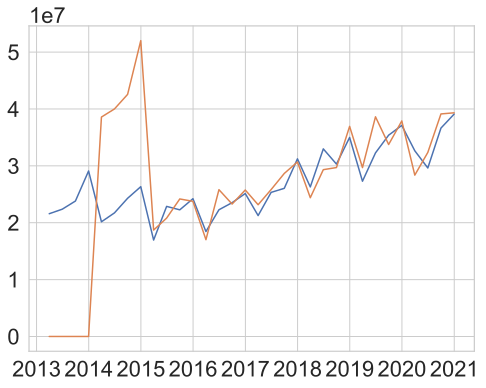

In [586]:
plt.figure(figsize = (8,6))
plt.plot(orders_quarter_train[['total_sales', 'ARIMA_predictions']][:])

In [587]:
mae(orders_quarter_train['total_sales'][8:], orders_quarter_train['ARIMA_predictions'][8:])

1940028.0140621085

In [588]:
cross_validation(orders_quarter_train[1:], data_name='total_sales', pred_name = 'ARIMA_predictions')[0]#.mean()

,train,test
split_1,2.170932e+07,7.849636e+06
split_2,1.285163e+07,8.164639e+05
split_3,8.769791e+06,2.149158e+06
split_4,7.139379e+06,2.431475e+06


In [680]:
orders_quarter_test['ARIMA_pred'] = arima_mod.forecast(4)

mae(orders_quarter_test.total_sales,orders_quarter_test['ARIMA_pred'])

7043316.855659982

### Power SARMA

Памятую о квадратичном тренде, обнаруженном при выполнении ДЗ2, попробуем сделать ариму на остатках от power transform. Параметр d занулим, т.к. ряд  в результате преобразования стационарный.

In [660]:
from scipy.optimize import curve_fit

def func(x,p,a):
    return x**p+a

x = [i for i in range(len(orders_quarter_train))]

popt, _ = curve_fit(func,x,  orders_quarter_train['total_sales'])
p = popt[0]
a = popt[1]
print(p,a)


4.838766698281733 23996365.334835354


In [661]:
y_hat = func(x,p,a)

In [662]:
residuals = orders_quarter_train.total_sales - y_hat

In [663]:
arima_mod_pt = ARIMA(residuals, seasonal_order =(3,0,1,4)).fit()
predictions = arima_mod_pt.predict()

In [664]:
x_ = [i for i in range(len(orders_quarter_train))]

In [666]:
y_hat = func(x_,p,a)

In [670]:
predictions = y_hat + predictions

In [676]:
orders_quarter_train['Power_SARMA_predictions'] = predictions

[]

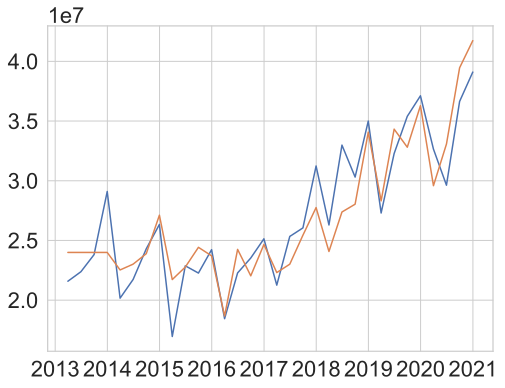

In [679]:
plt.figure(figsize = (8,6))
plt.plot(orders_quarter_train[['total_sales', 'Power_SARMA_predictions']][:])
plt.plot()

In [678]:
mae(orders_quarter_train.total_sales, predictions)

1961448.3219826622

In [ ]:
orders_quarter_test['ARIMA_pred'] = arima_mod.forecast(4)

mae(orders_quarter_test.total_sales,orders_quarter_test['ARIMA_pred'])

In [688]:
## OOB

pow_SARMA_fc = arima_mod_pt.forecast(4)
x_fc = [i for i in range(len(orders_quarter_train)+4)][-4:]
pow_basis = func(x_fc,p,a)
oob_pred = pow_basis + pow_SARMA_fc
orders_quarter_test['Power_SARMA_pred'] = oob_pred

In [691]:
mae(orders_quarter_test.total_sales, oob_pred)

3621108.737880951

### Небольшой блендинг моделей на oob

In [692]:
orders_quarter_test['blend']  = orders_quarter_test.drop(columns = 'total_sales').mean(axis=1)

In [695]:
orders_quarter_test

,total_sales,tes_pred,ARIMA_pred,Power_SARMA_preds,blend
load_date,,,,,
2021-03-31,34352222.77,3.126917e+07,3.692135e+07,4.042448e+07,3.620500e+07
2021-06-30,42767467.13,3.511943e+07,2.958199e+07,3.956233e+07,3.475458e+07
2021-09-30,44954072.89,3.753725e+07,3.831663e+07,4.586834e+07,4.057407e+07
2021-12-31,47650879.14,4.160195e+07,4.186967e+07,5.194366e+07,4.513842e+07


In [693]:
mae(orders_quarter_test.total_sales, orders_quarter_test['blend'])

4189530.146698041

[]

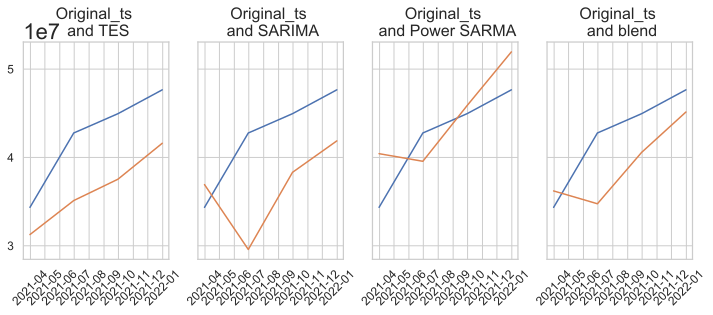

In [704]:
fig, axes = plt.subplots(nrows = 1, ncols =4, sharex=True, sharey=True, figsize = (12,4), )


axes[0].set_title('Original_ts \n and TES',size=16)
axes[0].plot(orders_quarter_test.total_sales)
axes[0].plot(orders_quarter_test.tes_pred)

axes[1].set_title('Original_ts \n and SARIMA', size = 16)
axes[1].plot(orders_quarter_test.total_sales)
axes[1].plot(orders_quarter_test.ARIMA_pred)

axes[2].set_title('Original_ts \n and Power SARMA', fontsize = 16)
axes[2].plot(orders_quarter_test.total_sales)
axes[2].plot(orders_quarter_test.Power_SARMA_preds)

axes[3].set_title('Original_ts \n and blend', fontsize = 16)
axes[3].plot(orders_quarter_test.total_sales)
axes[3].plot(orders_quarter_test.blend)

for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=12, verticalalignment = 'top')
    plt.yticks(fontsize=12)

plt.plot()

In [716]:
result_metrics = {}
for column in orders_quarter_test.drop(columns='total_sales'):
    result_metrics.update({i: mae(orders_quarter_test.total_sales, orders_quarter_test[column])})

In [717]:
pd.Series(result_metrics).sort_values()

Power_SARMA_preds    3.621109e+06
blend                4.189530e+06
tes_pred             6.049209e+06
ARIMA_pred           7.043317e+06
dtype: float64

### Выводы

лучше всех себя на данном датасете показала себя модификация SARIMA где вместо дифференцирования для превращения ряда в стационарный использовался power transform.
Вместе с тем, блендинг трех лучших моделей кажется предпочтительным, т.к. поводов ожидать  устойчивости этого тренда не очень много 